## BB Model applied to NBA Basketball
Soccer Model: http://nbviewer.ipython.org/github/akhilketkar/am207-project-soccer/blob/master/daniel_weitzenfeld_variation_bb_model_ak_updates.ipynb

### Important Note
To show the parallels to soccer we've kept the soccer terminology. All references to "goals" here are in fact points. 

###Code

We first import the necessary libraries

In [4]:
%matplotlib inline
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc
import urllib2
import pymc.graph as pymcgr
from IPython.display import Image
import datetime

###Functions to retrieve data and make tables
Next we write some generic functions that will get the data for the relevant year from the football data website and clean it to be in the format we need. We get rid of the many columns in there that relate to betting


In [15]:
## this is where all the helper funcitons are stored
import messy
reload(messy)

<module 'messy' from 'messy.pyc'>

# Get the data and create classification
Now we actually get the data we want.

In [6]:
# define the years you want to get the data (e.g. 2012-2013 season is 1213)
year_c = 1314
year_p = 1213

# get data
data_c = messy.get_NBA_data(year_c)
teams, matches_c = messy.clean_data(data_c,add_outcomes= True, midweek=False,relegation= False, champ=False)

# get data for the previous year
# for now this is how we're binning teams into classes
data_p = messy.get_NBA_data(year_p)
teams_p, matches_p = messy.clean_data(data_p,add_outcomes= True, midweek=False,relegation= False, champ=False)

# create season table for the previous year
season_tbl_p = messy.create_season_table_NBA(matches_p,teams_p)

# classify teams into groups based on their finish the previous season
num_classes = 3

# get the rank and merge into the main table
ranking = season_tbl_p[['team','position']].copy()
ranking['class'] =  np.repeat(np.arange(num_classes),len(ranking.team)/num_classes +1)[:len(ranking.team)]
ranking = ranking.drop('position',axis=1)

# merge with current data to get previous ranking
teams = pd.merge(teams,ranking,how='left',left_on='team',right_on='team')
teams.loc[teams['class'].isnull(),'class'] = num_classes - 1

###Set up variables needed for the model

We now set up the variables that will be used to build the model. We need to go from pandas dataframes to numpy arrays.

In [7]:
# these variables are used in the modelling.
observed_home_goals = matches_c.home_goals.values
observed_away_goals = matches_c.away_goals.values
home_team = matches_c.i_home.values
away_team = matches_c.i_away.values
team_class = np.array(teams['class'].values,dtype='int')
num_teams = len(matches_c.i_home.unique())
num_games = len(home_team)

# this is not necessarily needed but it improves performance
g = matches_c.groupby('i_away')
att_starting_points = np.log(g.away_goals.mean())
g = matches_c.groupby('i_home')
def_starting_points = -np.log(g.away_goals.mean())


###Model Setup
Here we set up the actual model using pymc 

In [8]:
#hyperpriors
home = pymc.Normal('home', 0, .0001, value=0)
tau_att = pymc.Gamma('tau_att', .1, .1, value=10)
tau_def = pymc.Gamma('tau_def', .1, .1, value=10)

# one intercept per class of team
intercept_star = pymc.Normal('intercept_star', 0, .0001, value=np.zeros(num_classes), size=num_classes)

# trick to code classes of intercepts
@pymc.deterministic
def intercept(intercept_star=intercept_star,team_class=team_class):
    intercept_c = intercept_star.copy()
    return intercept_c[team_class]


#team-specific parameters
atts_star = pymc.Normal("atts_star", 
                        mu=0, 
                        tau=tau_att, 
                        size=num_teams, 
                        value=att_starting_points.values)
defs_star = pymc.Normal("defs_star", 
                        mu=0, 
                        tau=tau_def, 
                        size=num_teams, 
                        value=def_starting_points.values) 

# trick to code the sum to zero contraint
@pymc.deterministic
def atts(atts_star=atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star)
    return atts

@pymc.deterministic
def defs(defs_star=defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    return defs

# home scoring parameter and away scoring parameter
@pymc.deterministic
def home_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept[home_team] + 
                  home + 
                  atts[home_team] + 
                  defs[away_team])
  
@pymc.deterministic
def away_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept[away_team] + 
                  atts[away_team] + 
                  defs[home_team])   

# number of goals scored by each time
home_goals = pymc.Poisson('home_goals', 
                          mu=home_theta, 
                          value=observed_home_goals, 
                          observed=True)
away_goals = pymc.Poisson('away_goals', 
                          mu=away_theta, 
                          value=observed_away_goals, 
                          observed=True)

## set up the full model
mcmc = pymc.MCMC([home, intercept_star, intercept, 
                  tau_att, tau_def, 
                  home_theta, away_theta, 
                  atts_star, defs_star, atts, defs, 
                  home_goals, away_goals])

## run the actual MCMC sampling for all our variables
mcmc.sample(200000, 40000, 50)

 [-----------------100%-----------------] 200000 of 200000 complete in 342.0 sec

###Check convergence
It's important to check convergence in these models

Plotting intercept_star_0
Plotting intercept_star_1
Plotting intercept_star_2


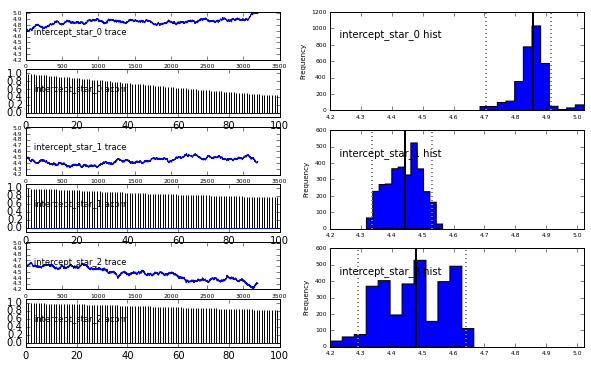

In [9]:
# Check if the intercept is actually producing differnt means for the different classes
pymc.Matplot.plot(intercept_star,path="../Figures/")

###$\tau_{att}$
Does appear to have converged.

Plotting tau_att


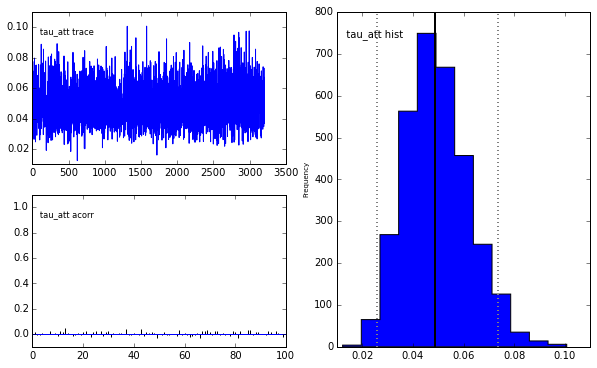

In [10]:
pymc.Matplot.plot(tau_att,path="../Figures/")


###$\tau_{def}$
This looks like it has converged

Plotting tau_def


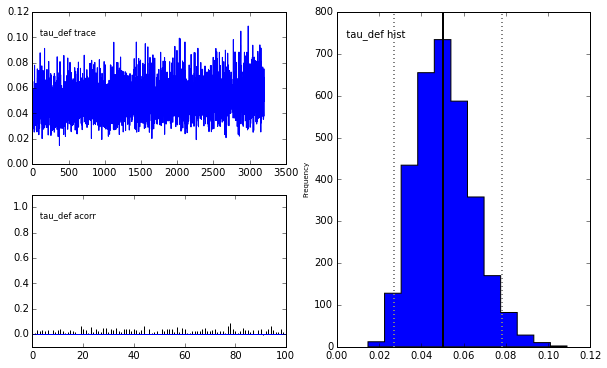

In [11]:
pymc.Matplot.plot(tau_def,path="../Figures/")


###$home$
This looks like it has converged

Plotting home


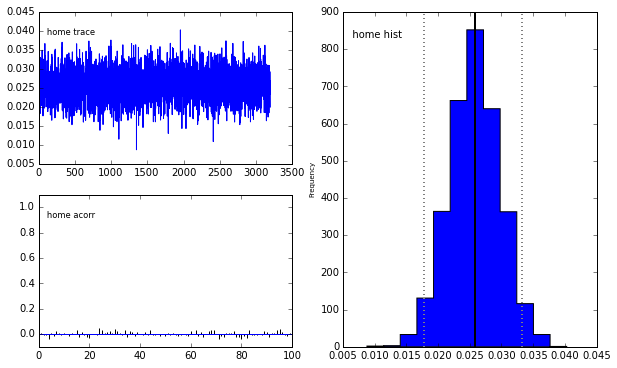

In [12]:
pymc.Matplot.plot(home,path="../Figures/")

###Check Model Hierarchy

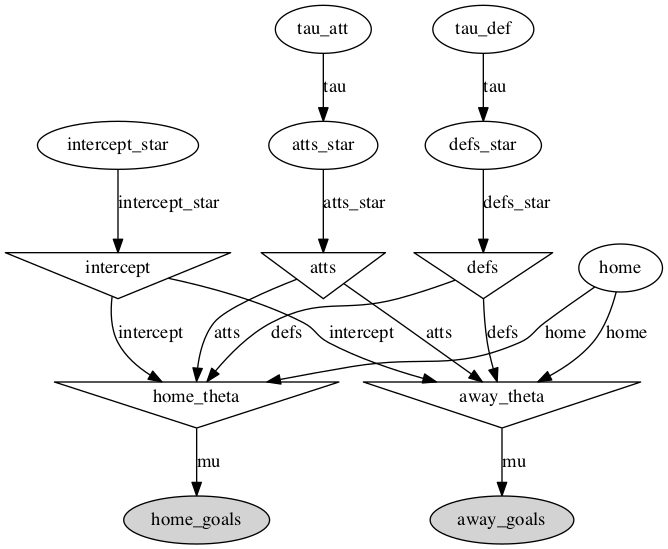

In [13]:
## Here we display the model we created to ensure that it agrees with the model we had set out to create
model_graph = pymcgr.graph(mcmc)
Image(model_graph.create_png())

###Testing
Now we try to test (first in-sample) as to how out model works. We simulate draws from our model and simulate an entire season. We then see how this compares to the real outcomes

In [20]:
simuls = messy.simulate_seasons(matches_c,teams,atts,defs,home,intercept,100)
g = simuls.groupby('team')
season_hdis = pd.DataFrame({'goals_for_lower': g.gf.quantile(.05),
                            'goals_for_median': g.gf.median(),
                            'goals_for_upper': g.gf.quantile(.95),
                            'goals_against_median': g.ga.median(),
                            })

obs_season = messy.create_season_table_baseball(matches_c,teams)


###Plots of Simulation
We now plot the results of our simulation vs the observed data

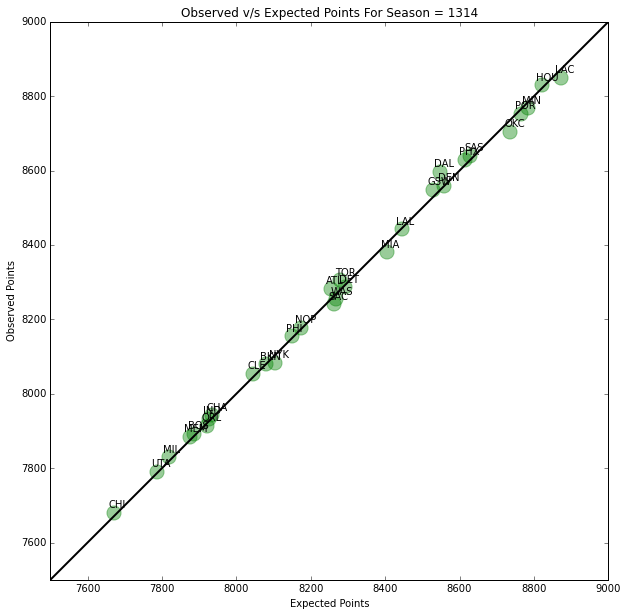

In [31]:
# merge the observed and the simulated data
model_comp = pd.merge(obs_season[["team","gf","ga"]],season_hdis,left_on="team",right_index=True)

# new figure
plt.figure(figsize=(10,10))

# plot the goals scored
plt.scatter(model_comp.goals_for_median.values,model_comp.gf.values,color="green",s=200,alpha=0.4)

# plot the 45 degree line so we can get a sense for how good the fit is
plt.plot([7500,9000],[7500,9000],color="black",lw=2)

# annotate with the name of the club
for t,x,y in zip(model_comp.team.values,model_comp.goals_for_median.values,model_comp.gf.values):
    plt.annotate(t, xy=(x,y), xytext = (-5,5), textcoords = 'offset points')

plt.xlabel("Expected Points")
plt.ylabel("Observed Points")
plt.xlim((7500,9000))
plt.ylim((7500,9000))
plt.title("Observed v/s Expected Points For Season = " + str(year_c), fontsize="large")
plt.savefig("../Figures/obsVSexpPointsNBA"+str(year_c)+".png",format="png")

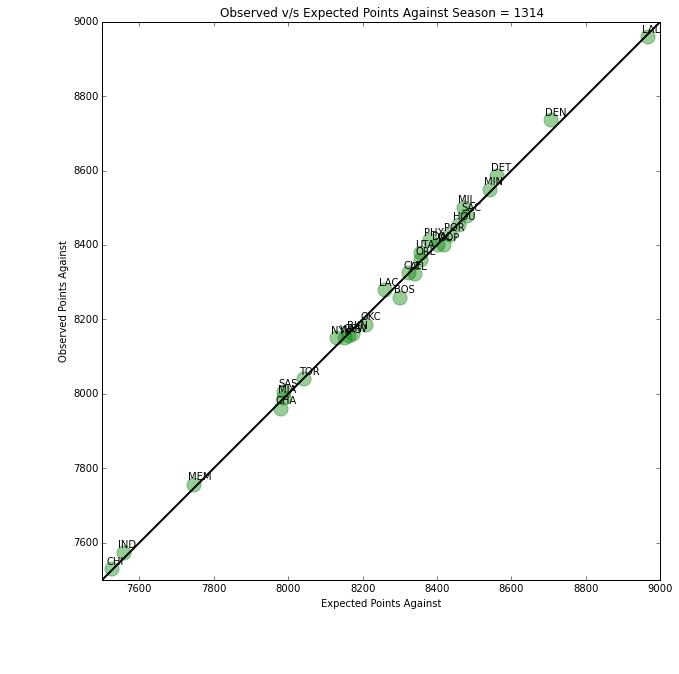

In [32]:
# new figure
plt.figure(figsize=(10,10))

# plot the goals scored
plt.scatter(model_comp.goals_against_median.values,model_comp.ga.values,color="green",s=200,alpha=0.4)

# plot the 45 degree line so we can get a sense for how good the fit is
plt.plot([7500,9000],[7500,9000],color="black",lw=2)

# annotate with the name of the club
for t,x,y in zip(model_comp.team.values,model_comp.goals_against_median.values,model_comp.ga.values):
    plt.annotate(t, xy=(x,y), xytext = (-5,5), textcoords = 'offset points')

plt.xlabel("Expected Points Against")
plt.ylabel("Observed Points Against")
plt.xlim((7500,9000))
plt.ylim((7500,9000))
plt.title("Observed v/s Expected Points Against Season = " + str(year_c), fontsize="large")
plt.savefig("../Figures/obsVSexpPointsAgainstNBA"+str(year_c)+".png",format="png")

###Relative Strengths of Teams
Now we plot the relative strengths of each time against each other. The y axis is each team's attacking stength (higher is better) and the x axis is their defensive strength (lower is better). The plot also shows the mean goal scoring ability of the team depending on the group to which it belongs.

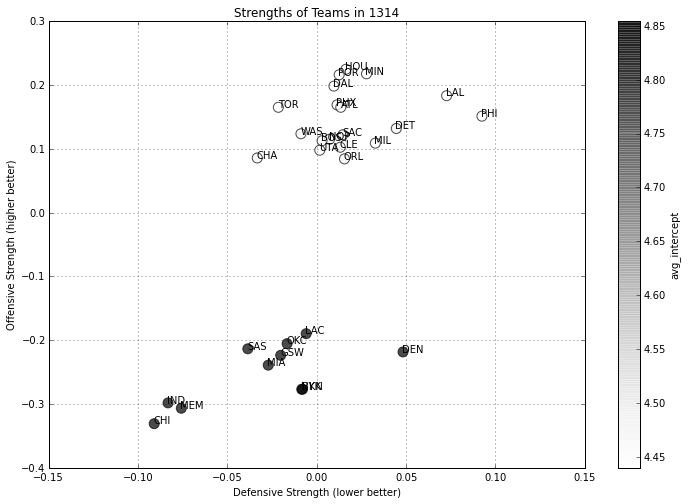

In [28]:
# get team parameters
team_params = messy.create_team_param_table(teams,atts,defs,home,intercept)

# plot
ax = team_params.plot("avg_def","avg_att",kind="scatter",figsize=(12,8),alpha=0.7,s=100,c="avg_intercept")

# annotate
for t,x,y in zip(team_params.team,team_params.avg_def,team_params.avg_att):
    ax.annotate(t,xy=(x,y))

plt.xlabel("Defensive Strength (lower better)")
plt.ylabel("Offensive Strength (higher better)")
plt.title("Strengths of Teams in "+ str(year_c))
plt.savefig("../Figures/relStrengthBasketball"+str(year_c)+".png",format="png")
